In [1]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Sequential

import numpy as np
import matplotlib.pyplot as plt

import sys
from tqdm import tqdm

# Загрузка данных

In [2]:
from tensorflow.keras.datasets.mnist import load_data

In [3]:
(X_train, y_train), (X_test, y_test) = load_data()

In [4]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

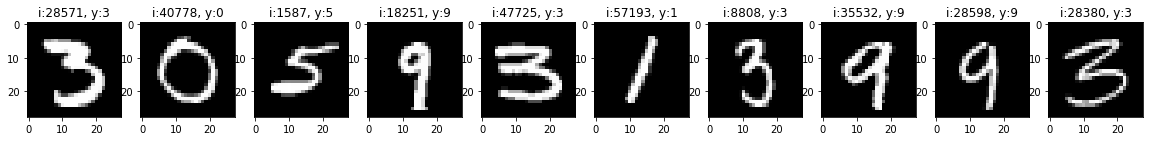

In [70]:
_, ax = plt.subplots(1,10, figsize=(20,5))
for i in range(10):
    num = np.random.randint(0, X_train.shape[0])
    ax[i].imshow(X_train[num], cmap='gray')
    ax[i].set_title("i:{}, y:{}".format(num, y_train[num]))
plt.show()

# Полносвязная сеть

In [76]:
X_train_proc = X_train.reshape(-1, np.product(X_train.shape[1:3]))
y_train_ohe = tf.keras.utils.to_categorical(y_train)
X_test_proc = X_test.reshape(-1, np.product(X_test.shape[1:3]))
y_test_ohe = tf.keras.utils.to_categorical(y_test)

PIC_SIZE = int(np.product(X_train.shape[1:3]))

X_train_proc.shape, y_train_ohe.shape, X_test_proc.shape, y_test_ohe.shape

((60000, 784), (60000, 10), (10000, 784), (10000, 10))

In [59]:
model = Sequential()
model.add(L.Input(int(PIC_SIZE)))
model.add(L.Dense(int(PIC_SIZE), activation='relu'))
model.add(L.Dense(10, activation='softmax'))
model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [60]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 784)               615440    
_________________________________________________________________
dense_31 (Dense)             (None, 10)                7850      
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________


In [61]:
history = model.fit(X_train_proc, y_train_ohe, epochs=10, validation_data=(X_test_proc, y_test_ohe))

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 3.5571 - accuracy: 0.9135 - val_loss: 0.8753 - val_accuracy: 0.9477
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.9636 - accuracy: 0.9533 - val_loss: 1.3975 - val_accuracy: 0.9402
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.7192 - accuracy: 0.9644 - val_loss: 0.9398 - val_accuracy: 0.9602
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6620 - accuracy: 0.9697 - val_loss: 0.7381 - val_accuracy: 0.9686
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5273 - accuracy: 0.9751 - val_loss: 0.9816 - val_accuracy: 0.9634
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5112 - accuracy: 0.9769 - val_loss: 0.8474 - val_accuracy: 0.9734
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4852 - accuracy: 0.9796 - val_loss: 1.2733 - val_accuracy:

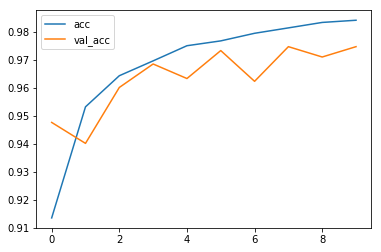

In [62]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

# GAN

In [72]:
SAMPLE_SIZE = 10
PIC_SIZE=28*28

In [73]:
generator = Sequential()
generator.add(L.Dense(256, input_dim=SAMPLE_SIZE))
generator.add(L.LeakyReLU(0.2))
generator.add(L.Dense(512))
generator.add(L.LeakyReLU(0.2))
generator.add(L.Dense(1024))
generator.add(L.LeakyReLU(0.2))
generator.add(L.Dense(PIC_SIZE, activation='tanh'))

In [74]:
discriminator = Sequential()

discriminator.add(L.Dense(1024, input_dim=PIC_SIZE))
discriminator.add(L.LeakyReLU(0.2))
discriminator.add(L.Dropout(0.3))

discriminator.add(L.Dense(512))
discriminator.add(L.LeakyReLU(0.2))
discriminator.add(L.Dropout(0.3))

discriminator.add(L.Dense(256))
discriminator.add(L.LeakyReLU(0.2))
discriminator.add(L.Dropout(0.3))

discriminator.add(L.Dense(1, activation='sigmoid'))

In [75]:
discriminator.trainable = False
gan_inputs = L.Input(shape=(SAMPLE_SIZE,))
x = generator(gan_inputs)
gan_outputs = discriminator(x)

gan = tf.keras.models.Model(inputs=gan_inputs, outputs=gan_outputs)

In [76]:
discriminator.compile(optimizer='adam', loss='binary_crossentropy')
gan.compile(optimizer='adam', loss='binary_crossentropy')

In [77]:
digits = []
Dloss = []
Gloss = []
X_train_proc = X_train.reshape(X_train.shape[0],-1)/255*2 - 1

In [80]:
X_train_proc.min(), X_train_proc.max(), generated_images.min(), generated_images.max()

(-1.0, 1.0, -0.9999877, 0.99999833)

In [81]:
EPOCHS = 20
BATCH_SIZE = 128

for i in range(EPOCHS):
    for j in range(int(X_train_proc.shape[0]/BATCH_SIZE)):
        # train discriminator
        noise = np.random.normal(0,1,size=(BATCH_SIZE, SAMPLE_SIZE))
        generated_images = generator.predict(noise)    
        X_train_disc = np.concatenate([X_train_proc[np.random.randint(0, X_train.shape[0], BATCH_SIZE)],
                                       generated_images])
        y_train_disc = np.concatenate([np.full(BATCH_SIZE, 1, dtype='float'), 
                                       np.zeros(BATCH_SIZE, dtype='float')])
        discriminator.trainable = True
        dloss = discriminator.train_on_batch(X_train_disc, y_train_disc)
        Dloss.append(dloss)
            
        #train generator
        X_train_gan = np.random.normal(0,1,size=(BATCH_SIZE, SAMPLE_SIZE))
        y_train_gan = np.ones(shape=BATCH_SIZE)
        discriminator.trainable = False    
        gloss = gan.train_on_batch(X_train_gan, y_train_gan)
        Gloss.append(gloss)
    
    print("Epoch {}, dloss {}, gloss {}".format(i, dloss, gloss))
    digits.append(generator.predict(np.random.normal(0,1,size=(3,SAMPLE_SIZE))))    

Epoch 0, dloss 5.199748992919922, gloss 0.00041875019087456167
Epoch 1, dloss 5.273015022277832, gloss 0.00041165767470374703
Epoch 2, dloss 5.260573387145996, gloss 0.0004546963900793344
Epoch 3, dloss 5.303339958190918, gloss 0.0005258923629298806
Epoch 4, dloss 5.3934245109558105, gloss 0.00045247512753121555
Epoch 5, dloss 5.250465393066406, gloss 0.00047622653073631227
Epoch 6, dloss 5.45176887512207, gloss 0.000344656320521608
Epoch 7, dloss 5.538447380065918, gloss 0.00032472360180690885
Epoch 8, dloss 5.466198921203613, gloss 0.0002797921188175678
Epoch 9, dloss 5.51558256149292, gloss 0.0002555025275796652
Epoch 10, dloss 5.4486002922058105, gloss 0.00030294014140963554
Epoch 11, dloss 5.566544532775879, gloss 0.0002733804867602885
Epoch 12, dloss 5.5005059242248535, gloss 0.00028093851869925857
Epoch 13, dloss 5.635229110717773, gloss 0.0002341564977541566
Epoch 14, dloss 5.55867862701416, gloss 0.0002685044310055673
Epoch 15, dloss 5.717648029327393, gloss 0.0002884015557356

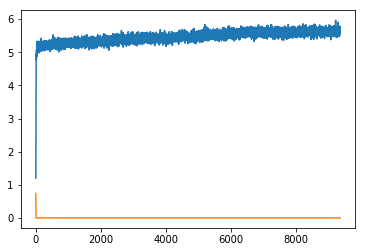

In [82]:
plt.plot(Dloss)
plt.plot(Gloss)
plt.show()

In [94]:
len(digits)
show_digits = digits[::10]

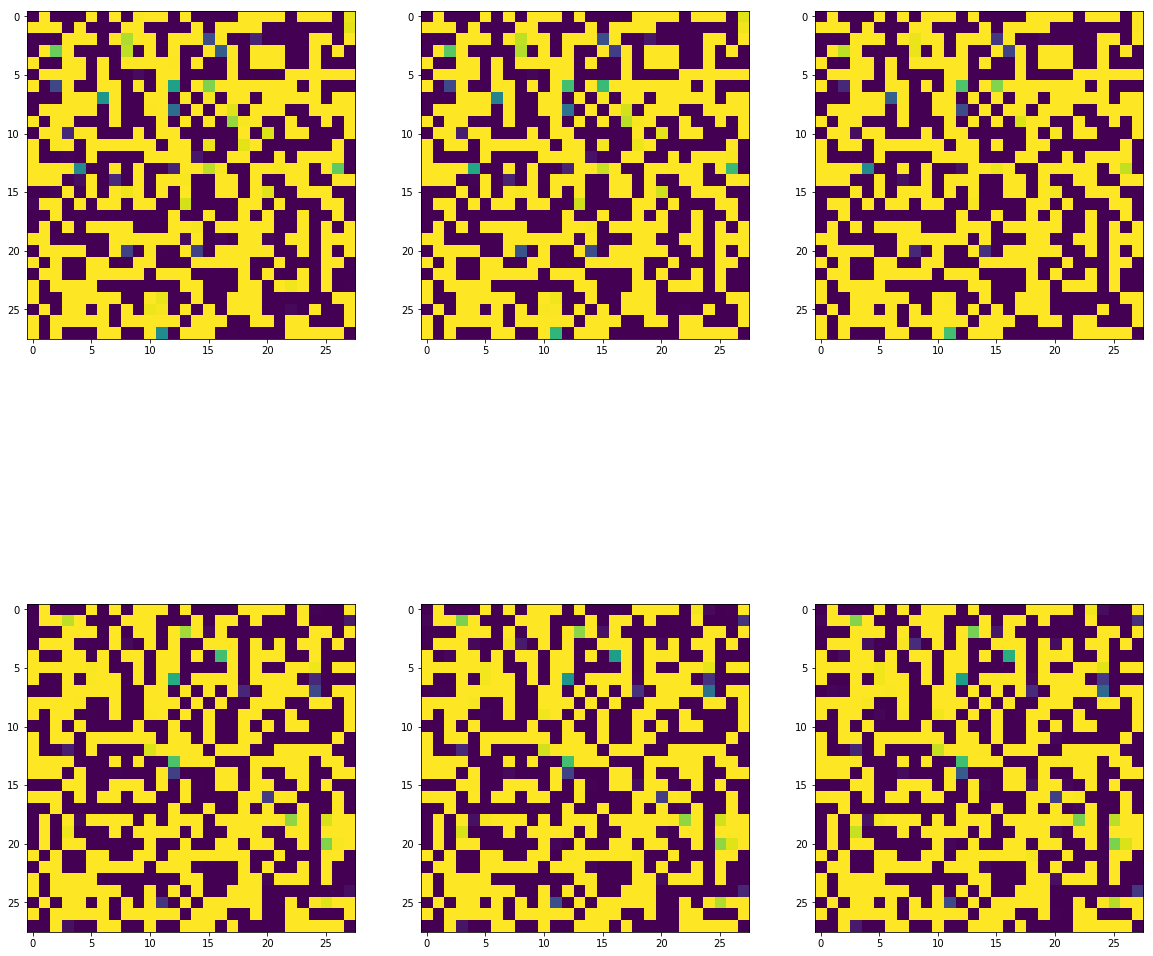

In [95]:
_, ax = plt.subplots(len(show_digits),3, figsize=(20,20))
for i in range(len(show_digits)):
    for j, digit in enumerate(show_digits[i]):
        ax[i][j].imshow(digit.reshape(28,28))
plt.show()

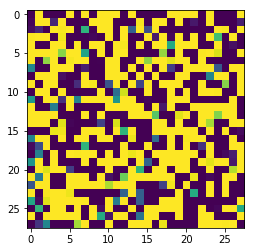

In [96]:
plt.imshow(generator.predict(np.random.normal(0,1,size=SAMPLE_SIZE).reshape(1,-1)).reshape(28,28))
plt.show()